In [1]:
%matplotlib inline

In [2]:
import os,sys
import requests
from matplotlib import pyplot as plt
import numpy as np
sys.path.insert(0, os.path.abspath('../src'))
from interface import Detector, Run

# Some useful experiment information
## General experiment setup:

In [3]:
expt='cxic0415'

In [4]:
geom_file = f'/cds/data/psdm/cxi/{expt}/calib/CsPad::CalibV1/CxiDs1.0:Cspad.0/geometry/0-end.data'

In [5]:
det = Detector(geom_file)

## some run specifics

In [6]:
run_idx=36

In [7]:
run = Run(expt, run_idx, det=det, image_type=np.int16)

9158 images of shape 1738x1747 and type int16
Estimated size: 55.61 GB


# PCA of a small batch

In [28]:
images = run._retrieve_image_batch(batch_size=200)

In [9]:
def show_image(image, title=None):
    vmin = np.mean(image)-3*np.std(image)
    vmax = np.mean(image)+3*np.std(image)
    fig, ax = plt.subplots(1,1,figsize=(3,3),dpi=180)
    if title is not None:
        ax.set_title(title)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    fig.colorbar(im, orientation='vertical')
    plt.show()

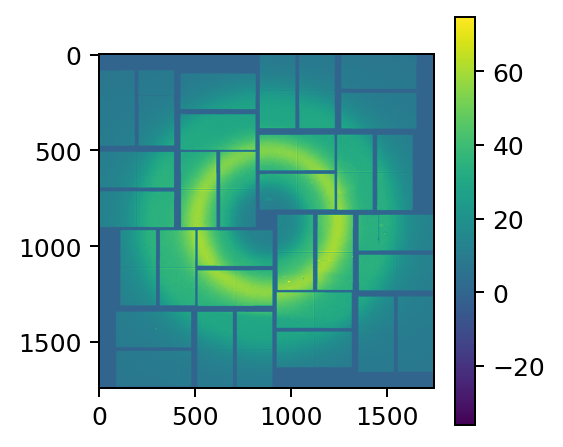

In [10]:
show_image(np.mean(images,axis=0))

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA()
pca.fit(images.reshape(images.shape[0], images.shape[1]*images.shape[2]))

PCA()

In [13]:
comps = pca.transform(images.reshape(images.shape[0], images.shape[1]*images.shape[2]))

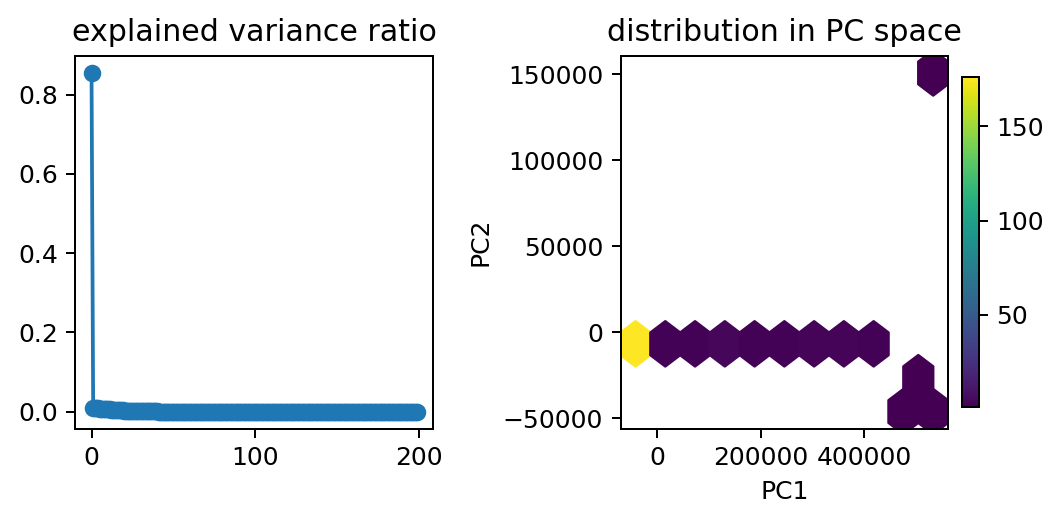

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3),dpi=180)
ax1.set_title('explained variance ratio')
ax1.plot(pca.explained_variance_ratio_, 'o-')
ax2.set_title('distribution in PC space')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
im2 = ax2.hexbin(comps[:,0], comps[:,1], mincnt=1,gridsize=10)
cbar = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [15]:
eigen_images = np.dot(comps.T,images.reshape(images.shape[0], images.shape[1]*images.shape[2])).reshape(images.shape[0], images.shape[1], images.shape[2])

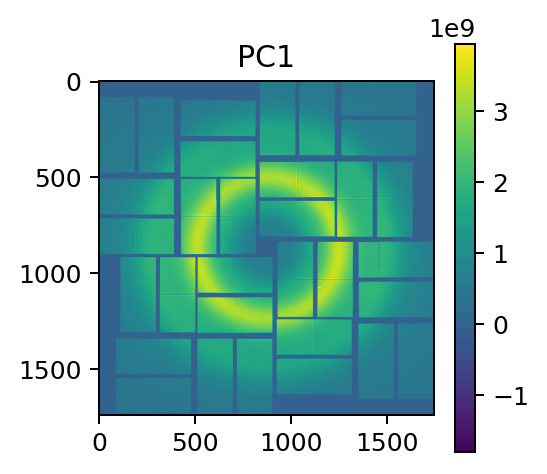

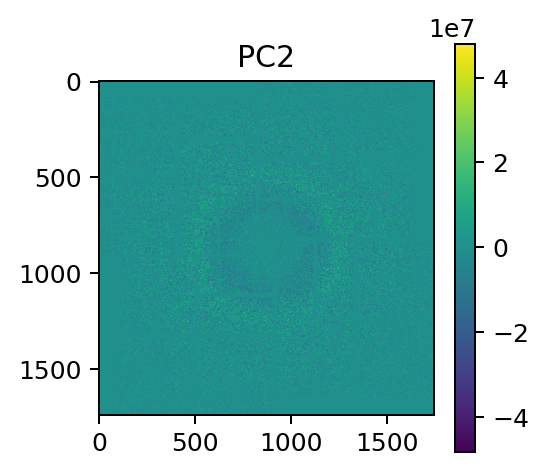

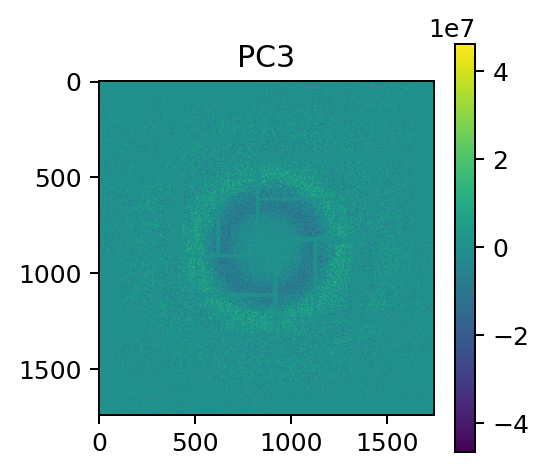

In [16]:
for i in np.arange(3):
    show_image(eigen_images[i], title=f'PC{i+1}')

## some low level clustering

In [17]:
bulk_indices     = np.where(comps[:,0]<0)[0]
outliers_indices = np.where(comps[:,0]>0)[0]
print(bulk_indices.shape, outliers_indices.shape)

bulk_images     = np.copy(images[bulk_indices,...])
outliers_images = np.copy(images[outliers_indices,...])

bulk_mean     = np.mean(bulk_images,axis=0) 
outliers_mean = np.mean(outliers_images,axis=0) 
bulk_std     = np.std(bulk_images,axis=0) 
outliers_std = np.std(outliers_images,axis=0) 

(176,) (24,)


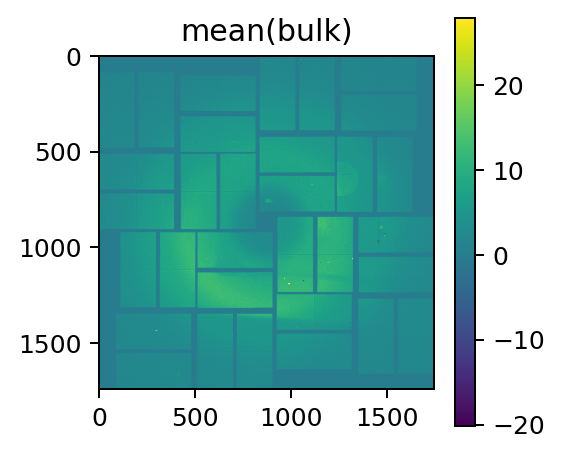

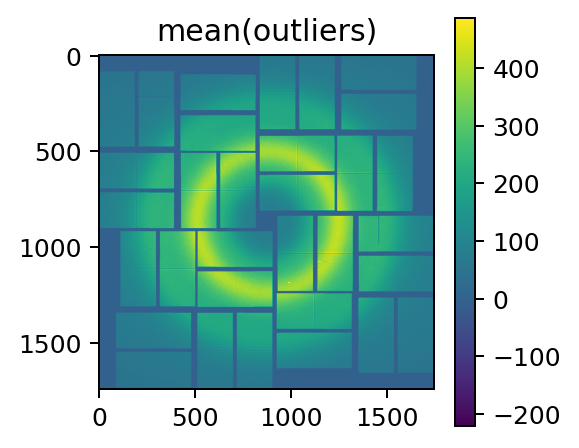

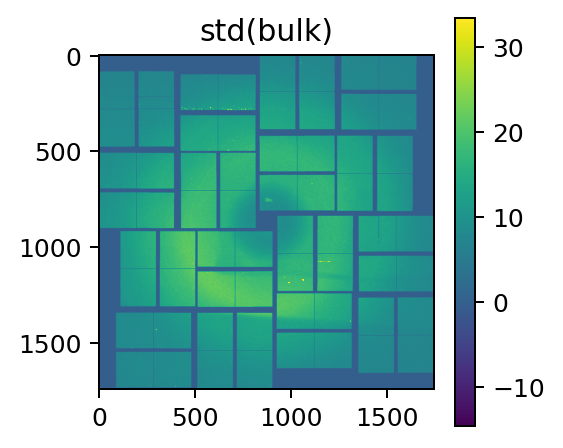

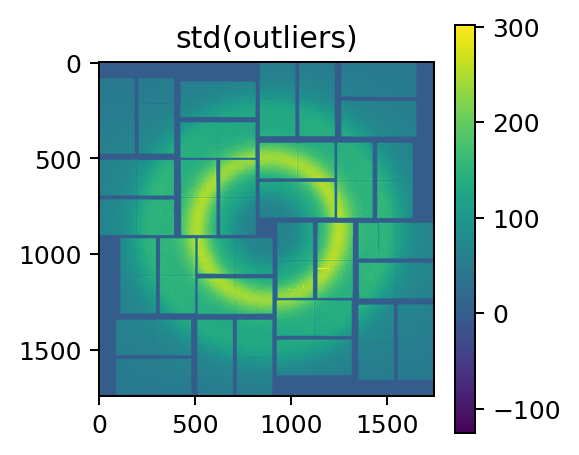

In [18]:
for image, title in zip((bulk_mean, outliers_mean, bulk_std, outliers_std),('mean(bulk)','mean(outliers)','std(bulk)','std(outliers)')):
    show_image(image, title=title)

# PCA of the whole run

In [8]:
from sklearn.decomposition import IncrementalPCA

In [9]:
import time

batch [1/91]
> batch loaded in 14.70 s
> partial fit in 131.66 s
> partial transform in 4.36 s


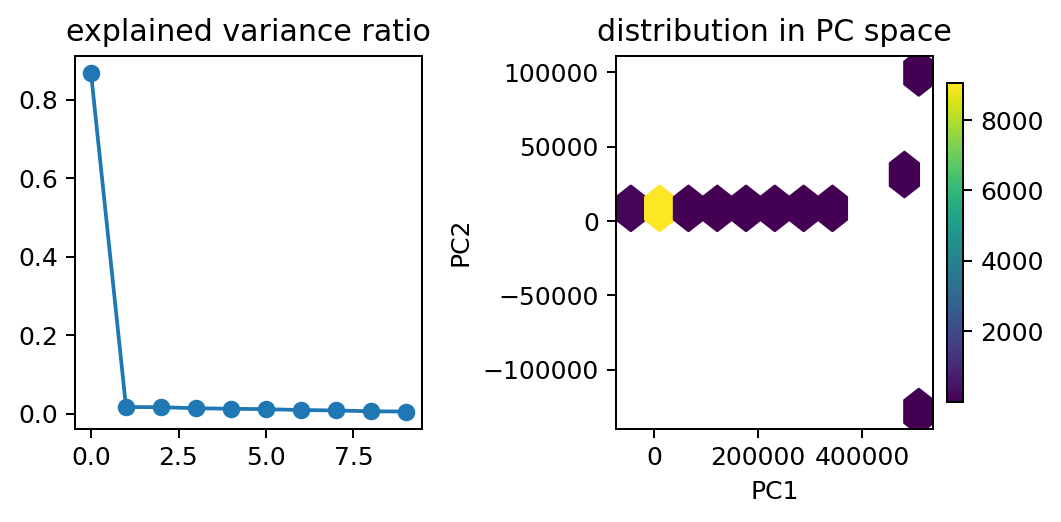

total time = 151.09 s
batch [2/91]
> batch loaded in 14.92 s
> partial fit in 162.36 s
> partial transform in 4.40 s


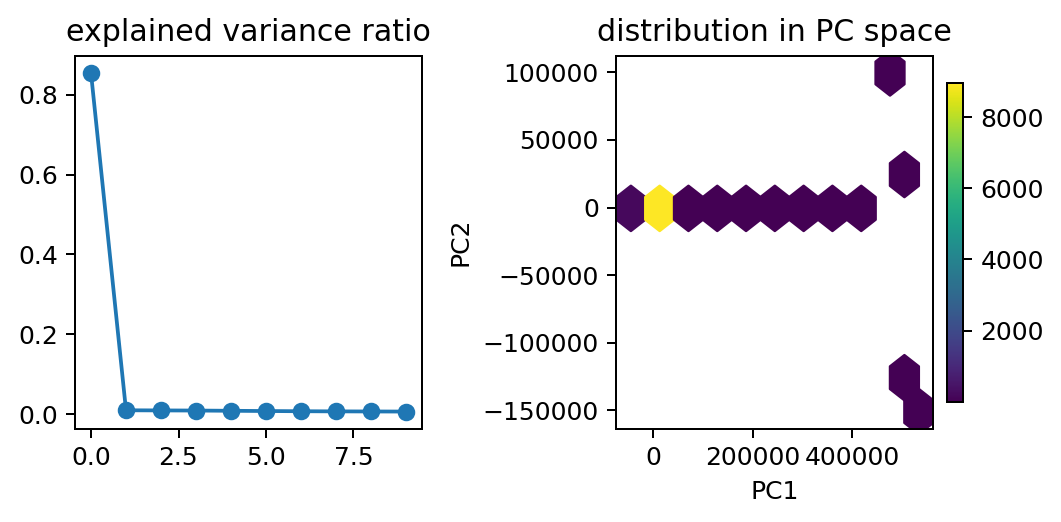

total time = 182.06 s
batch [3/91]
> batch loaded in 15.69 s
> partial fit in 188.97 s
> partial transform in 6.01 s


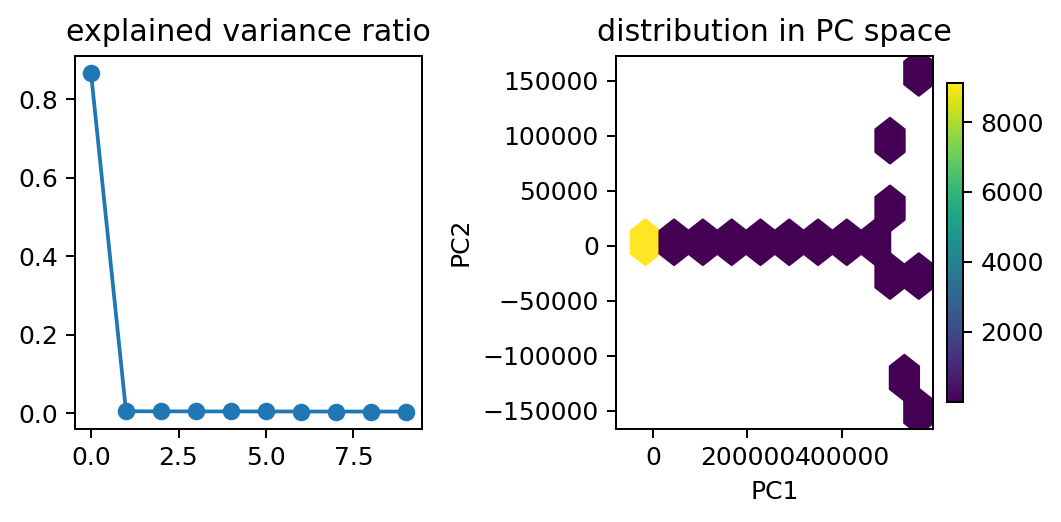

total time = 211.08 s
batch [4/91]
> batch loaded in 17.15 s
> partial fit in 175.54 s
> partial transform in 4.16 s


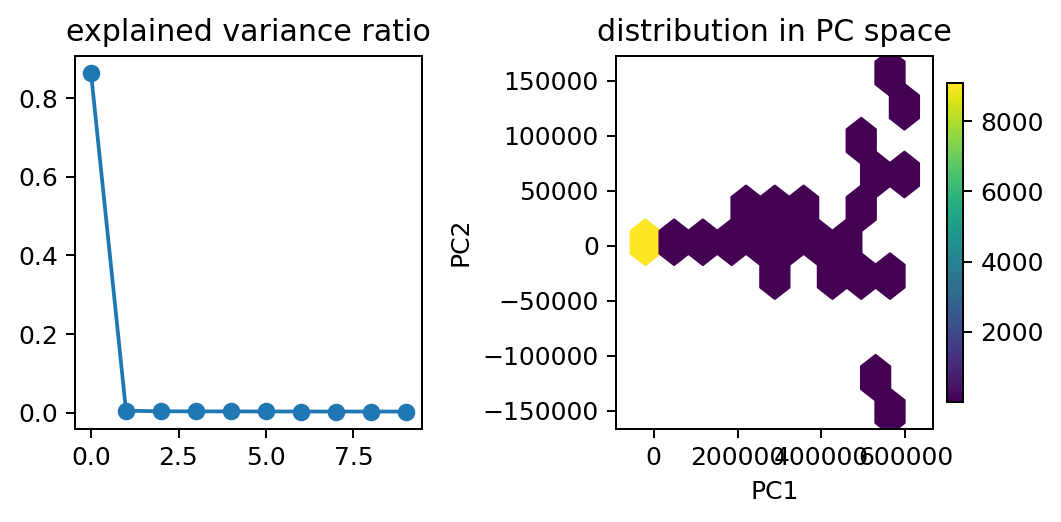

total time = 197.22 s
batch [5/91]
> batch loaded in 17.07 s
> partial fit in 171.66 s
> partial transform in 5.02 s


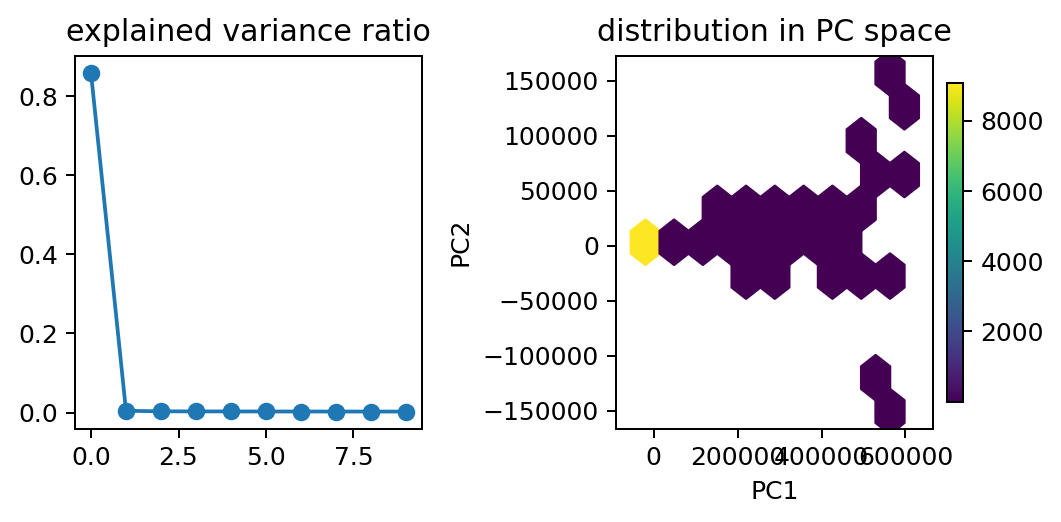

total time = 194.15 s
batch [6/91]
> batch loaded in 17.23 s
> partial fit in 170.46 s
> partial transform in 6.07 s


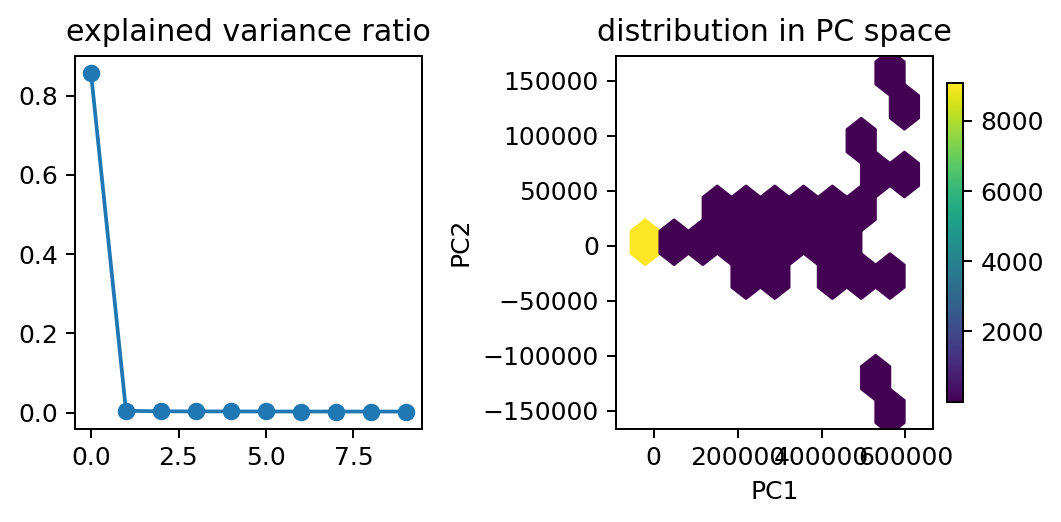

total time = 194.16 s
batch [7/91]
> batch loaded in 17.41 s
> partial fit in 151.22 s
> partial transform in 4.64 s


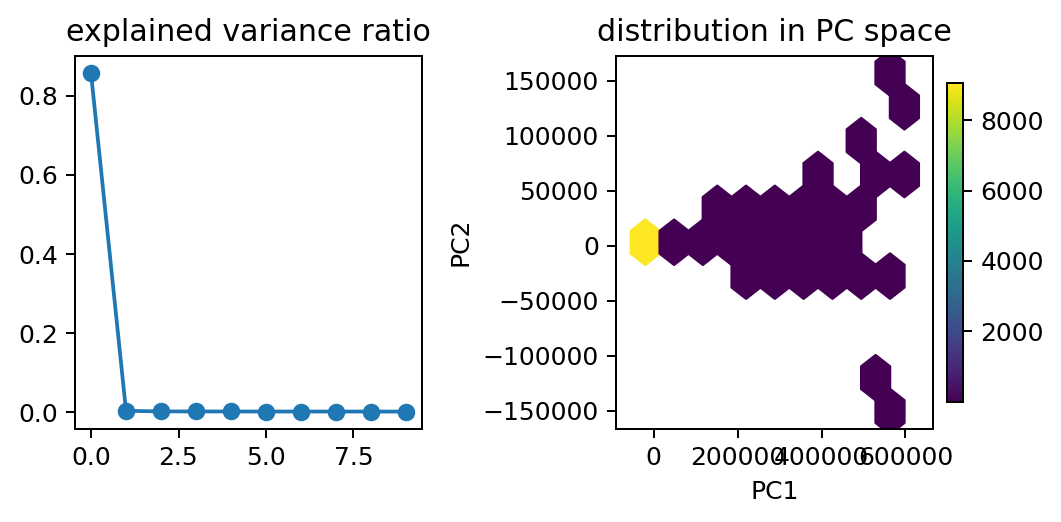

total time = 173.78 s
batch [8/91]
> batch loaded in 17.01 s
> partial fit in 169.84 s
> partial transform in 4.76 s


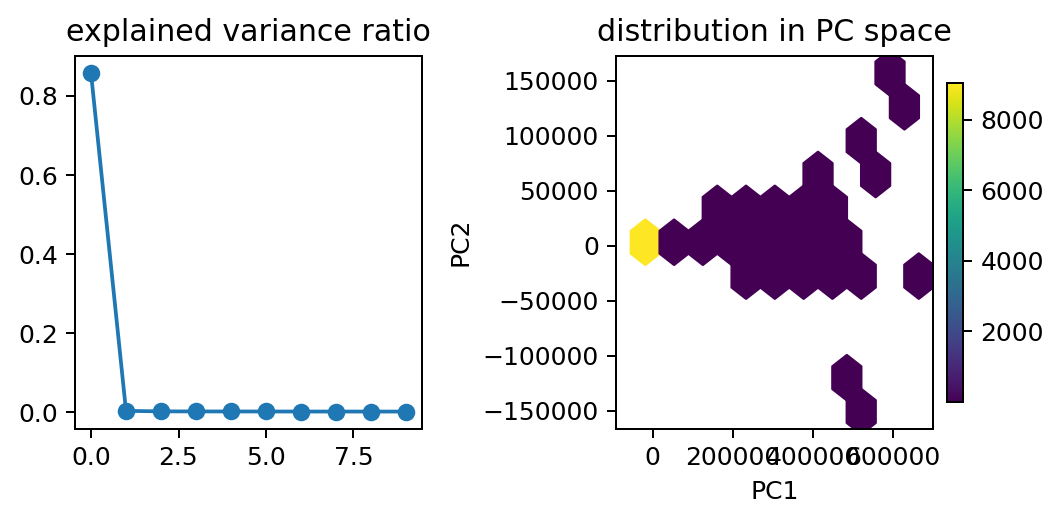

total time = 191.99 s
batch [9/91]
> batch loaded in 17.41 s
> partial fit in 158.04 s
> partial transform in 4.59 s


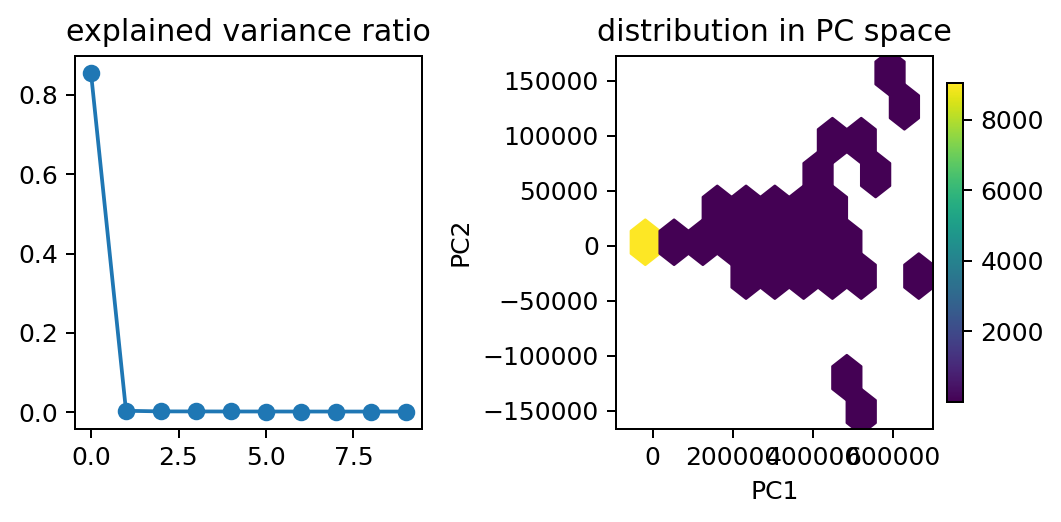

total time = 180.44 s
batch [10/91]
> batch loaded in 18.03 s


In [ ]:
ipca = IncrementalPCA(n_components=10)
comps = np.zeros((run._n_images,10))
batch_size=100
n_batches = run._n_images//batch_size
for i in range(0, n_batches):
    
    print(f'batch [{i+1}/{n_batches}]')
    
    start_time = time.time()
    images = run._retrieve_image_batch(batch_id=i,batch_size=batch_size)
    load_time = time.time()
    print(f'> batch loaded in {(load_time - start_time):.2f} s')
    
    ipca.partial_fit(images.reshape((images.shape[0],images.shape[1]*images.shape[2])))
    fit_time = time.time()
    print(f'> partial fit in {(fit_time - load_time):.2f} s')
    
    comps[i*batch_size:(i+1)*batch_size,:] = ipca.transform(images.reshape((images.shape[0],images.shape[1]*images.shape[2])))
    transform_time = time.time()   
    print(f'> partial transform in {(transform_time - fit_time):.2f} s')
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3),dpi=180)
    ax1.set_title('explained variance ratio')
    ax1.plot(ipca.explained_variance_ratio_, 'o-')
    ax2.set_title('distribution in PC space')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    im2 = ax2.hexbin(comps[:,0], comps[:,1], mincnt=1,gridsize=10)
    cbar = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    end_time = time.time()
    print(f'total time = {(end_time - start_time):.2f} s')